In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import wall_growth_kit as walkit
import seaborn as sns
import math

%load_ext autoreload
%autoreload 2

In [3]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

In [4]:
def sum_3(temp_vals,temp_params):
    # Here, we calculate the LHS of the radial stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
#     temp_1=(temp_k*temp_dr/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_nu*(temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_nu*(temp_n)+temp_dr*temp_n*(temp_n+1)/(2*temp_r))
    return temp_1


def sum_4(temp_vals,temp_params):
    # Here, we calculate the LHS of the longitudinal stress constraint, given a fixed radius r, and a sum limit given
    # by temp_vals[2]. Temp_vals[0] is the growth rate, temp_vals[1] is the inner radius, temp_vals[2] is
    # the sum limit, temp_vals[3] is the alpha value for this summation.
    temp_nu=temp_params['nu']
    temp_dr=temp_params['dr']
    temp_k=temp_params['K']
    temp_dt=temp_params['dt']
    # parameters that are varied to solve matters. Note that this is just the growth rate, since
    # growth rate and timestep are not linearly independent.
    temp_gfact = temp_vals[0]*temp_dt
    temp_r=temp_vals[1]
    # parameters that are specific to this sum
    temp_n, temp_a=temp_vals[2], temp_vals[3] # note that alpha must be set externally
    #
    temp_x=np.exp(temp_gfact) # exponential growth rate factor for each turnover event.
    #
    temp_1=((temp_k*temp_dr)/(temp_a-temp_nu**2))*(temp_r*temp_a*((temp_x**(temp_n+1)-temp_x)/(temp_x-1)-temp_n)+temp_nu*temp_dr*temp_n*(temp_n+1)/2 \
        +temp_dr*temp_a*(((temp_n+1)*temp_x**(temp_n+2)-(temp_n+2)*temp_x**(temp_n+1)+1)/(temp_x-1)**2-1-temp_n*(temp_n+1)/2) \
        +temp_nu*temp_dr**2*temp_n*(temp_n+1)*(2*temp_n+1)/(temp_r*6))
    return temp_1
    
    
def min_eq_v2(temp_vals,temp_params):
    # We aim to find the roots of this equation in order to determine the possible growth and radii
    # at steady state.
    temp_sum_lim=temp_params['N']-1  # number of layers - 1
    
    temp_r=temp_vals[1]
    temp_n_cutoff=np.floor(temp_params['strain_cutoff']*temp_r/temp_params['dr'])
    
    
    temp_vals1=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha1']])  # this is the innermost sum
    temp_vals2=list(temp_vals)+list([temp_sum_lim, temp_params['alpha2']])  # this is the outermost sum
    temp_vals3=list(temp_vals)+list([temp_n_cutoff, temp_params['alpha2']])  # this is the difference sum 
#     print(temp_vals1, temp_vals2, temp_vals3)
    # defining terms here
    temp_dr=temp_params['dr']
    temp_p=temp_params['P']
    temp_k=temp_params['K']
    # pressure rhs terms for radial and longitudinal constraints respectively
    temp_p1=(temp_r+temp_dr)*temp_p # radial constraint
    temp_p2=((temp_r+temp_dr)**2)*temp_p/(2)  # longitudinal constraint
    # Here we break the summations into their respective parts for the different alpha values. Note that this
    # is possible because the different layers sum linearly.
    temp1=sum_3(temp_vals1,temp_params)+sum_3(temp_vals2,temp_params)-sum_3(temp_vals3,temp_params)-temp_p1
    temp2=sum_4(temp_vals1,temp_params)+sum_4(temp_vals2,temp_params)-sum_4(temp_vals3,temp_params)-temp_p2
#     temp1=sum_1(temp_vals2,temp_params)-temp_p1
#     temp2=sum_2(temp_vals2,temp_params)-temp_p2
#     print(temp_p1, temp_p2)
    return [temp1,temp2]

In [5]:
init=[0.01,0.42]
sol = optimize.root(min_eq_v2, init, args=(params),method='hybr')

In [6]:
sol.success

True

In [7]:
print('gr, radius', sol.x)
print('cutoff_layer', math.ceil(params['strain_cutoff']*sol.x[1]/params['dr']))

gr, radius [0.02238154 0.449365  ]
cutoff_layer 6


Okay, so this looks like it's doing a reasonable job, but it's having trouble converging within the fingertrap regime. We'll do two things. First, we'll confirm that this looks like our simulations are expected to.

In [34]:
np.arange(1,6,1)

array([1, 2, 3, 4, 5])

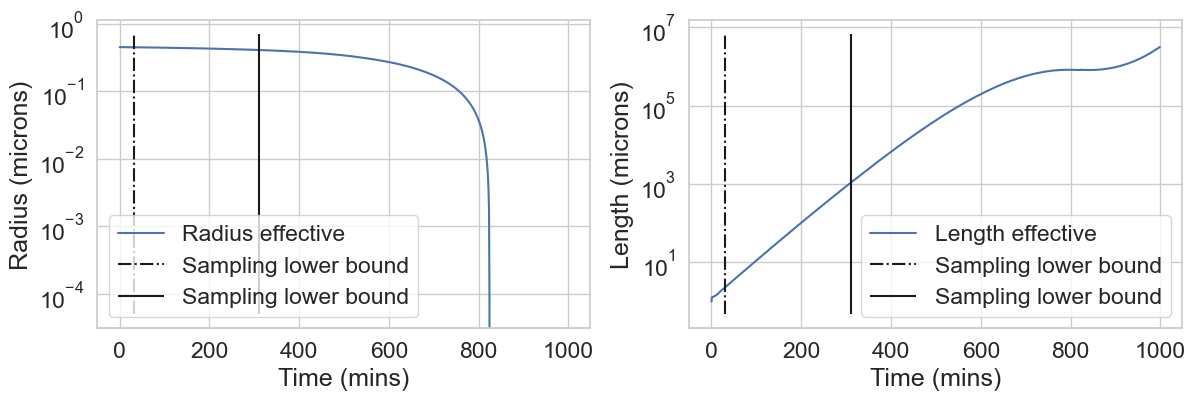

<Figure size 640x480 with 0 Axes>

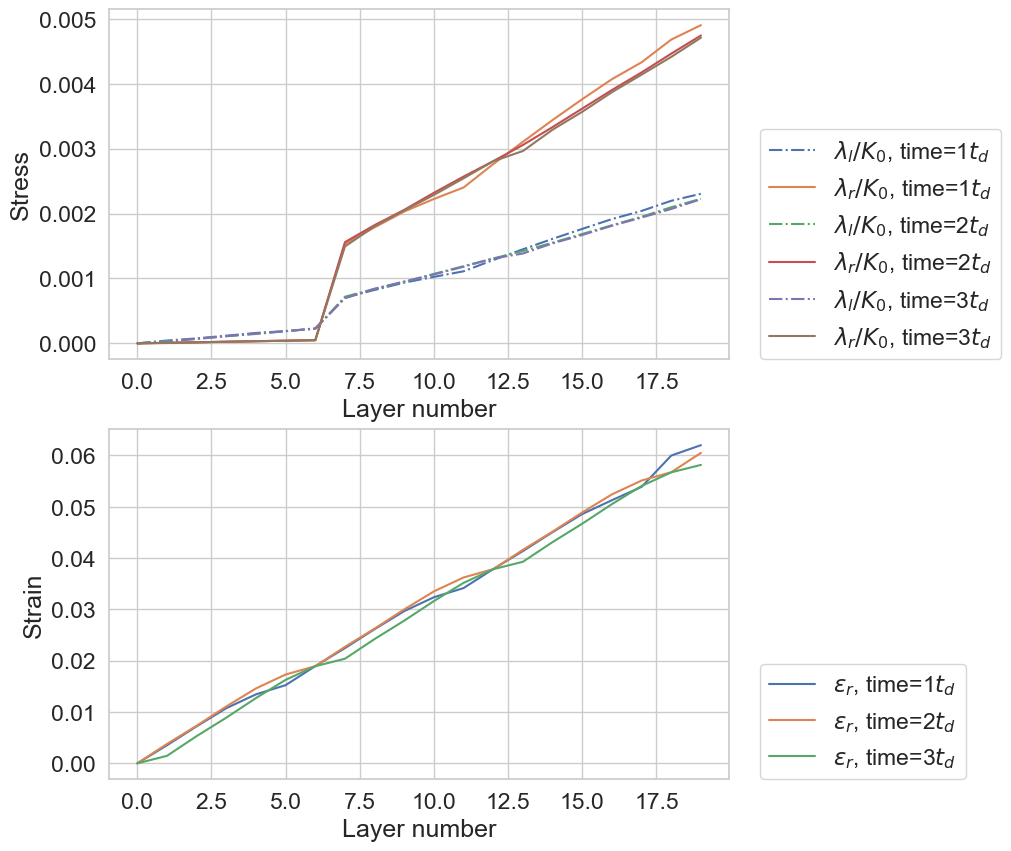

Growth rate (per min) = 0.02199
Doubling time  (mins) = 31.5164
Average cell radius = 0.43069
Theory growth rate and radius = [0.02238154 0.449365  ]


<Figure size 640x480 with 0 Axes>

In [67]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.16, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

numstep=1000
tvec=np.arange(numstep)
# ri,li=sol.x[1]*np.ones(int(num_layers)),1.0*np.exp(-sol.x[0]*np.arange(0,int(num_layers)).astype(float)*params['dt'])
ri,li=(sol.x[1])*np.ones(int(num_layers)),np.ones(num_layers)

# Cutoffs for analysis
ucutoff=np.nonzero(tvec>10*np.log(2)/sol.x[0])[0][0]
lcutoff=np.nonzero(tvec>np.log(2)/sol.x[0])[0][0]

radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt_strain_stiffening(tvec,ri,li,params)

rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)

dr=wall_thickness/num_layers
sns.set(font_scale=1.5,style='whitegrid')
fig=plt.figure(figsize=[14,4])
ax=plt.subplot(1,2,1)
# plt.semilogy(tvec[1:len(rad_vals)-1],rad_vals[1:len(rad_vals)-1],label='Radius')
plt.semilogy(tvec,eff_rad,label='Radius effective')
temp_lims=ax.get_ylim()
plt.vlines(lcutoff,ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-.',label='Sampling lower bound')
plt.vlines(ucutoff,ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-',label='Sampling lower bound')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
ax=plt.subplot(1,2,2)
# plt.semilogy(tvec[1:len(rad_vals)-1],l_vals[1:len(l_vals)-1],label='Length')
plt.semilogy(tvec,eff_length,label='Length effective')
temp_lims=ax.get_ylim()
plt.vlines(lcutoff,ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-.',label='Sampling lower bound')
plt.vlines(ucutoff,ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-',label='Sampling lower bound')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.show()
fig.savefig('./quality_figs/sample_trace_1_radii_length.png',bbox_inches='tight')
plt.clf()

fig=plt.figure(figsize=[8,10])
plt.subplot(2,1,1)
nu=np.copy(poisson_ratio)
for ind in np.arange(1,4,1):
    ind1=np.nonzero(tvec>ind*np.log(2)/sol.x[0])[0][0]
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    # Now we calculate the tensions in each layer
    alphas = alpha1 * (eps_r < strain_cutoff) + alpha2 * (
            eps_r >= strain_cutoff)  # this gives the
    # specific values for alpha for each layer in this configuration. Note that this is a vector.
    
    sig_l = dr*temp_si*((alphas/(alphas-nu**2))*eps_l+(nu/(alphas-nu**2))*eps_r) # the longitudinal tension in each layer 
    sig_r = dr*temp_si*((nu/(alphas-nu**2))*eps_l+(1/(alphas-nu**2))*eps_r) # the radial tension in each layer 
    plt.plot(sig_l,label=r'$\lambda_l/K_0$, time={}$t_d$'.format(ind),linestyle='-.')
    plt.plot(sig_r,label=r'$\lambda_r/K_0$, time={}$t_d$'.format(ind),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Stress')
plt.legend(loc=[1.05,0.0])

plt.subplot(2,1,2)
nu=np.copy(poisson_ratio)
for ind in np.arange(1,4,1):
    ind1=np.nonzero(tvec>ind*np.log(2)/sol.x[0])[0][0]
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
#     plt.plot(eps_l+1,label=r'$\ln|\epsilon_l+1|$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
    plt.plot(eps_r,label=r'$\epsilon_r$, time={}$t_d$'.format(ind),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Strain')
plt.legend(loc=[1.05,0.0])
plt.show()
fig.savefig('./quality_figs/sample_trace_1_stress_strain.png',bbox_inches='tight')
plt.clf()


out=scipy.stats.linregress(tvec[lcutoff:ucutoff],np.log(eff_length[lcutoff:ucutoff]))
print("Growth rate (per min) = {0}".format(np.around(out.slope,5)))
print("Doubling time  (mins) = {0}".format(np.around(np.log(2)/out.slope,4)))
print("Average cell radius = {0}".format(np.around(np.nanmean(eff_rad[lcutoff:ucutoff]),5)))
print("Theory growth rate and radius =", sol.x)

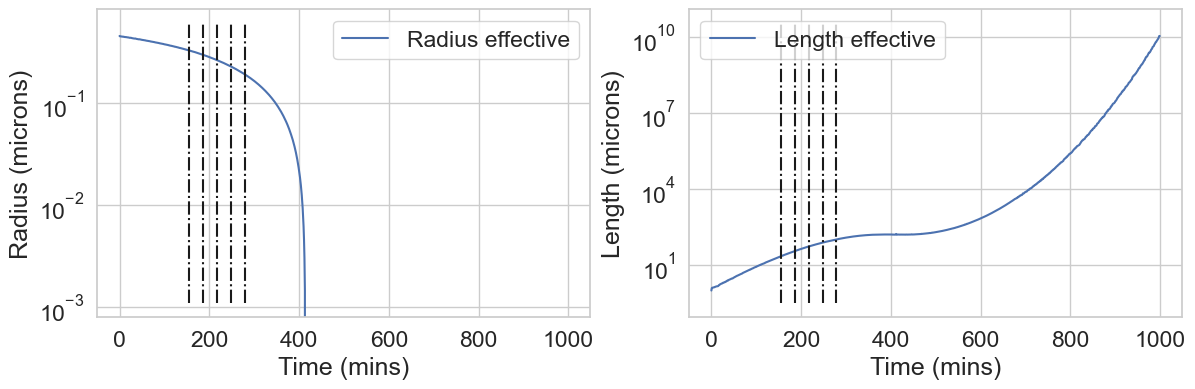

<Figure size 640x480 with 0 Axes>

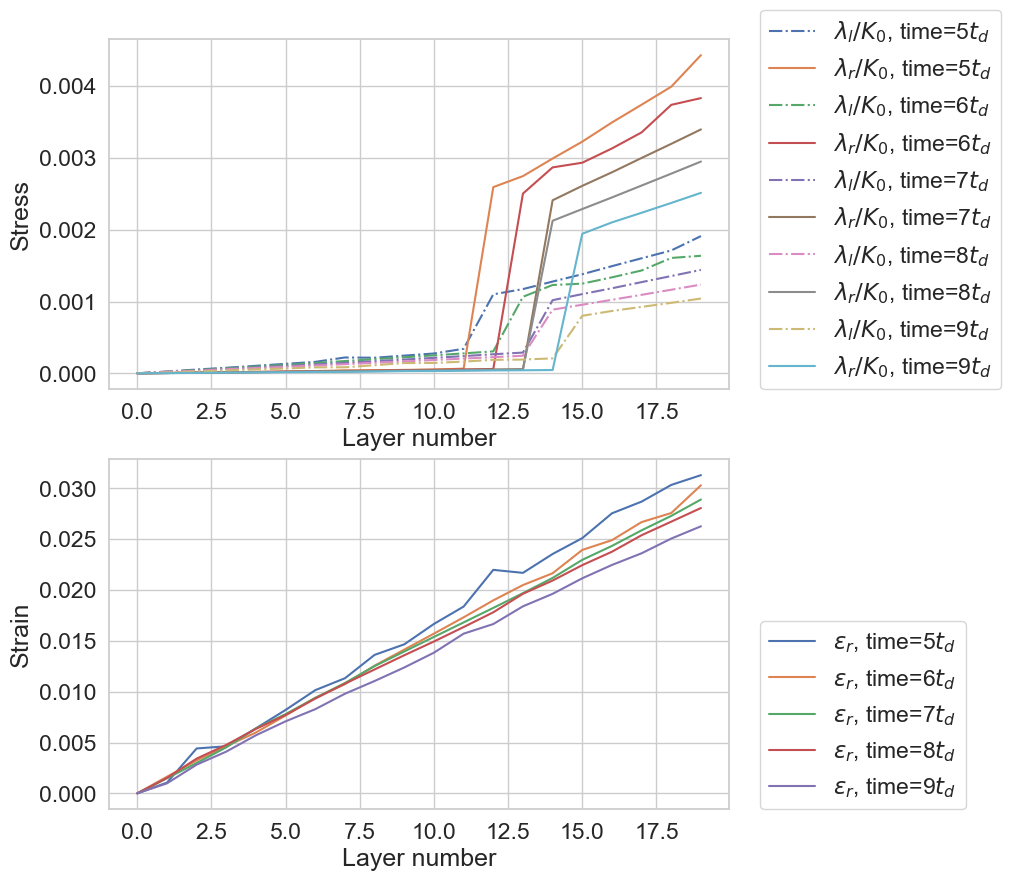

Growth rate (per min) = 0.01488
Doubling time  (mins) = 46.5942
Average cell radius = 0.30254
Theory growth rate and radius = [0.02238154 0.449365  ]


<Figure size 640x480 with 0 Axes>

In [71]:
pressure,num_layers=1.0,20.0
alpha1, alpha2, poisson_ratio=2.0, 0.14, 0.3
strain_cutoff=0.02  # note we are now specifying the cell starting radius, since otherwise we cannot solve for
# the steady state so readily. Here, n_cutoff-1 specifies how many layers in you need to go in order

cycle_range=np.arange(5,10,1)

turnover_rate=1.0
PK_rat=0.1
wall_thickness=0.03
num_layers=20
params={'P':pressure,'alpha1':alpha1,'alpha2':alpha2,'K':pressure/PK_rat,'nu':poisson_ratio, 'dt':1.0/turnover_rate,
        'dr':wall_thickness/(num_layers-1), 'N':num_layers, 'PK_rat':PK_rat,'strain_cutoff':strain_cutoff} 
# note we no longer define dt here.

numstep=1000
tvec=np.arange(numstep)
# ri,li=sol.x[1]*np.ones(int(num_layers)),1.0*np.exp(-sol.x[0]*np.arange(0,int(num_layers)).astype(float)*params['dt'])
ri,li=(sol.x[1])*np.ones(int(num_layers)),np.ones(num_layers)

# Cutoffs for analysis
ucutoff=np.nonzero(tvec>10*np.log(2)/sol.x[0])[0][0]
lcutoff=np.nonzero(tvec>np.log(2)/sol.x[0])[0][0]

radii,lengths,eff_rad,eff_length=walkit.sim_growth_abrupt_strain_stiffening(tvec,ri,li,params)

rad_vals=np.asarray([temp[0] for temp in radii if len(temp)>0])
l_vals=np.asarray([temp[0] for temp in lengths if len(temp)>0])
stiffnesses=np.ones(ri.shape)

dr=wall_thickness/num_layers
sns.set(font_scale=1.5,style='whitegrid')
fig=plt.figure(figsize=[14,4])
ax=plt.subplot(1,2,1)
# plt.semilogy(tvec[1:len(rad_vals)-1],rad_vals[1:len(rad_vals)-1],label='Radius')
plt.semilogy(tvec,eff_rad,label='Radius effective')
temp_lims=ax.get_ylim()
av,spread=np.sum(temp_lims)/2, (temp_lims[1]-temp_lims[0])/2
for ind in cycle_range:
    plt.vlines(ind*np.log(2)/sol.x[0],ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-.')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Radius (microns)')
ax=plt.subplot(1,2,2)
# plt.semilogy(tvec[1:len(rad_vals)-1],l_vals[1:len(l_vals)-1],label='Length')
plt.semilogy(tvec,eff_length,label='Length effective')
temp_lims=ax.get_ylim()
for ind in cycle_range:
    plt.vlines(ind*np.log(2)/sol.x[0],ymin=temp_lims[0], ymax=temp_lims[1],color='k', linestyle='-.')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Length (microns)')
plt.show()
fig.savefig('./quality_figs/sample_trace_3_fingertrap_radii_length.png',bbox_inches='tight')
plt.clf()

fig=plt.figure(figsize=[8,10])
plt.subplot(2,1,1)
nu=np.copy(poisson_ratio)
for ind in cycle_range:
    ind1=np.nonzero(tvec>ind*np.log(2)/sol.x[0])[0][0]
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
    # Now we calculate the tensions in each layer
    alphas = alpha1 * (eps_r < strain_cutoff) + alpha2 * (
            eps_r >= strain_cutoff)  # this gives the
    # specific values for alpha for each layer in this configuration. Note that this is a vector.
    
    sig_l = dr*temp_si*((alphas/(alphas-nu**2))*eps_l+(nu/(alphas-nu**2))*eps_r) # the longitudinal tension in each layer 
    sig_r = dr*temp_si*((nu/(alphas-nu**2))*eps_l+(1/(alphas-nu**2))*eps_r) # the radial tension in each layer 
    plt.plot(sig_l,label=r'$\lambda_l/K_0$, time={}$t_d$'.format(ind),linestyle='-.')
    plt.plot(sig_r,label=r'$\lambda_r/K_0$, time={}$t_d$'.format(ind),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Stress')
plt.legend(loc=[1.05,0.0])

plt.subplot(2,1,2)
nu=np.copy(poisson_ratio)
for ind in cycle_range:
    ind1=np.nonzero(tvec>ind*np.log(2)/sol.x[0])[0][0]
    temp_rval,temp_lval=radii[ind1][0],lengths[ind1][0]
    temp_ri,temp_li,temp_si=radii[ind1],lengths[ind1],stiffnesses
    
    eps_r = (temp_rval+dr*np.arange(0,len(temp_ri)).astype(float)-temp_ri)/temp_ri # radial strain in each layer 
    # based on equal spacing between layers of dr.
    eps_l = (temp_lval-temp_li)/temp_li # longitudinal strain in each layer
#     plt.plot(eps_l+1,label=r'$\ln|\epsilon_l+1|$, time={}'.format(np.around(tvec[ind1],2)),linestyle='-.')
    plt.plot(eps_r,label=r'$\epsilon_r$, time={}$t_d$'.format(ind),linestyle='-')
plt.xlabel('Layer number')
plt.ylabel('Strain')
plt.legend(loc=[1.05,0.0])
plt.show()
fig.savefig('./quality_figs/sample_trace_3_fingertrap_stress_strain.png',bbox_inches='tight')
plt.clf()


out=scipy.stats.linregress(tvec[lcutoff:ucutoff],np.log(eff_length[lcutoff:ucutoff]))
print("Growth rate (per min) = {0}".format(np.around(out.slope,5)))
print("Doubling time  (mins) = {0}".format(np.around(np.log(2)/out.slope,4)))
print("Average cell radius = {0}".format(np.around(np.nanmean(eff_rad[lcutoff:ucutoff]),5)))
print("Theory growth rate and radius =", sol.x)

Okay! So this is actually looking pretty good in terms of agreement. Let's now generate some plots for this model.